# Bayesian Inference of COVID-19 Spreading Rates in South Africa 

Follows methodology from:
* Bayesian Inference of COVID-19 Spreading Rates in South Africa
    Rendani Mbuvha, Tshilidzi Marwala
    medRxiv 2020.04.28.20083873; doi: https://doi.org/10.1101/2020.04.28.20083873 and
    
* Dehning, J., Zierenberg, J., Spitzner, F. P., Wibral, M., Neto, J. P., Wilczek, M., & Priesemann, V. (2020). Inferring COVID-19 spreading rates and potential change points for case number forecasts. arXiv preprint arXiv:2004.01105.



In [83]:
import sys
sys.path.append('..')
import datetime

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import datetime
import time as time_module
import sys
import os 
import scipy.stats
import theano
import matplotlib

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19



## Loading data from John Hopkins Corona Virus Resource Center 

https://coronavirus.jhu.edu/map.html

In [84]:
confirmed_cases = cov19.get_jhu_confirmed_cases()

date_data_begin = datetime.datetime(2020,6,1)
date_data_end   = cov19.get_last_date(confirmed_cases)

num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 12 
num_days_future = 180
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, 'South Africa',
                                     date_data_begin, date_data_end)




## Priors on dates for change points
Only starting from 15 june no further change points considered here

In [85]:
prior_date_level_3 =  datetime.datetime(2020,6,15)



change_points = [ dict(pr_mean_date_begin_transient = prior_date_level_3,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.4,
                      pr_sigma_lambda = 0.5)]


## SIR with priors specified below inference perfromed using No-U-Turn Sampler 

Hoffman, Matthew D., and Andrew Gelman. "The No-U-Turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo." J. Mach. Learn. Res. 15.1 (2014): 1593-1623..   

In [86]:

sir_traces_NUTS = []
sir_models = []

sir_model = cov19.SIR_with_change_points(new_cases_obs = np.diff(cases_obs),
                                     change_points_list = change_points,
                                    date_begin_simulation =date_begin_sim,
                                    num_days_sim=num_days_sim,
                                    diff_data_sim=diff_data_sim, 
                                   N=59e6,priors_dict=dict(pr_beta_I_begin = 20,
                                pr_median_lambda_0 =  0.4,
                                pr_sigma_lambda_0 = 0.7,
                                pr_median_mu = 1/8,
                                pr_sigma_mu = 0.2,
                                pr_median_delay = 5,
                                pr_sigma_delay = 0.2,
                                pr_beta_sigma_obs = 10))
                                
sir_models.append(sir_model)

with sir_model:
    step_NUTS = pm.NUTS()
    sir_traces_NUTS.append(pm.sample(model=sir_model, init='advi',step=step_NUTS, draws=200,tune=10))
    

pr_median_transient_len of change point 0 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3


Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay, mu, transient_len_0, transient_begin_0, lambda_1, lambda_0, I_begin]
Sampling 4 chains, 0 divergences: 100%|██████████| 840/840 [04:46<00:00,  2.93draws/s]
The acceptance probability does not match the target. It is 0.6740168884789551, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.3035756275500739, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.08644095134678793, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## Posterior Distributions of Parameters 

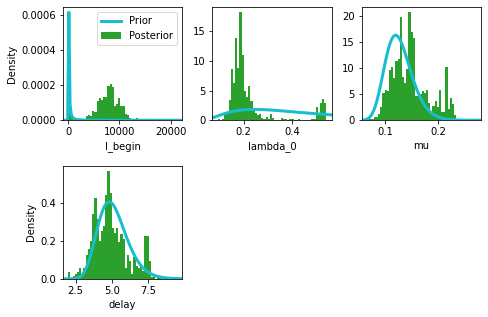

In [87]:
varnames = cov19.plotting.get_all_free_RVs_names(sir_models[0])
varnames = ['I_begin', 'lambda_0', 'mu', 'delay']
num_cols = 3
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(sir_models[0], sir_traces_NUTS[0], ax, varnames[i_ax],colors = ('tab:cyan', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


## Predictions 

Plots with data from 2020-06-01 to 2020-07-08


(737578.0, 737792.0)

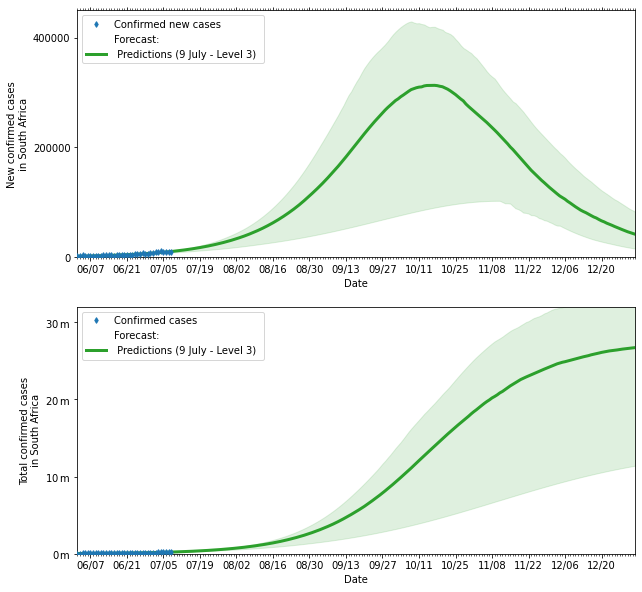

In [105]:
date_data_end_to_plot   = cov19.get_last_date(confirmed_cases)


cases_obs_to_plot = cov19.filter_one_country(confirmed_cases, 'South Africa',
                                     date_data_begin, date_data_end_to_plot)



def truncate_number(number, precision):
    return '{{:.{}f}}'.format(precision).format(number)  

def print_median_CI(arr, prec = 2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.mean(arr))
    perc1, perc2 = f_trunc(np.percentile(arr, q=2.5)), f_trunc(np.percentile(arr, q=97.5))
    return 'Median: {}\n95% CI: [{}, {}]'.format(med, perc1, perc2)
def conv_time_to_mpl_dates(arr):
    return matplotlib.dates.date2num([datetime.timedelta(days=float(date)) + date_begin_sim for date in arr])

print("Plots with data from {} to {}".format(date_data_begin.date().isoformat(), date_data_end.date().isoformat()))

trace = sir_traces_NUTS[0]
posterior = sir_traces_NUTS[:]


pos_letter = (-0.2, 1)


limit_lambda = (-0.1,0.5)
bins_lambda  = np.linspace(*limit_lambda, 30)

fig, axes = plt.subplots(2,1, figsize=(10,10), gridspec_kw={'height_ratios': [2,2]})

colors  = ['tab:green','tab:orange']
legends = ['Forecast: ', ' Predictions (9 July - Level 3) ']

ax = axes[0]

time1 = np.arange(-len(cases_obs)+2, 1)
mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
time_for_obs = np.arange(-len(cases_obs)+2, 1+len(cases_obs_to_plot)-len(cases_obs))
mpl_dates_for_obs = conv_time_to_mpl_dates(time_for_obs) + diff_data_sim + num_days_data

start_date = mpl_dates[0]
diff_cases = np.diff(cases_obs)
ax.plot(mpl_dates_for_obs, np.diff(cases_obs_to_plot), 'd', label='Confirmed new cases', 
        markersize=4, color='tab:blue', zorder=5)

new_cases_past = trace.new_cases[:,:num_days_data]
percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(new_cases_past, axis=0),color='tab:green', linewidth=3, zorder=-1)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:green')

ax.plot([],[], label=legends[0], alpha=0)
for trace_scen, color, legend in zip(posterior, colors, legends[1:]):
    new_cases_past = trace_scen.new_cases[:,:num_days_data]
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),'--',color=color, linewidth=1.5)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    end_date = mpl_dates_fut[-3]
    cases_future = trace_scen['new_cases'][:, num_days_data:].T
    
    median = np.median(cases_future, axis=-1)
    percentiles = (
    np.percentile(cases_future, q=2.5, axis=-1),
    np.percentile(cases_future, q=97.5, axis=-1),
    )

    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label=legend)
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.15, color=color)


ax.set_xlabel('Date')
ax.set_ylabel('New confirmed cases\nin South Africa')
ax.legend(loc='upper left')
ax.set_ylim(0, 450_000)

ax.locator_params(axis="y", nbins=4)

ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
ax.set_xlim(start_date, end_date)
ax.xaxis.set_ticks_position('both')


ax=axes[1]

time1 = np.arange(-len(cases_obs)+2, 1)
mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
ax.plot(mpl_dates_for_obs, cases_obs_to_plot[1:], 'd', label='Confirmed cases', markersize=4, color='tab:blue', 
            zorder=5)


cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:green', linewidth=3, zorder=-1)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:green')

ax.plot([],[], label=legends[0], alpha=0)
for trace_scen, color, legend in zip(posterior, colors, legends[1:]):
    new_cases_past = trace_scen.new_cases[:,:num_days_data]
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),'--',color=color, linewidth=1.5)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = np.cumsum(trace_scen['new_cases'][:, num_days_data:].T, axis=0) + cases_obs[-1]
  
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )

    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label=legend)
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.15, color=color)
    
ax.set_xlabel('Date')
ax.set_ylabel('Total confirmed cases\nin South Africa')
ax.legend(loc='upper left')
ax.set_ylim(0, 32_000_000)

ax.locator_params(axis="y", nbins=4)
func_format = lambda num, _: "${:.0f}\,$m".format(num/1_000_000)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2,byweekday=matplotlib.dates.SU))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

ax.set_xlim(start_date, end_date)
